# Exercice 1 : Lecture des données

Importer les donnees avec spark

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("taxi-ex1").config("spark.driver.memory", "6g").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

data = spark.read.option("header", "true").parquet("file:///home/victor/Epita/ING2/BDA/TP5/datasets/yellow_tripdata_2022-*.parquet")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/28 21:12:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Visualiser les données

In [2]:
data.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       1| 2022-10-01 00:03:41|  2022-10-01 00:18:39|            1.0|          1.7|       1.0|                 N|         249|         107|           1|        9.5|  3.0|    0.5|      2.6

In [3]:
data.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)



# Exercice 2 : Data Cleaning

Q1 – Calculer le nombre total de trajets dans le dataset.

In [4]:
data.count()

39656098

Q2 – Calculer le plus petit montant et le plus grand montant enregistré.

In [5]:
from pyspark.sql import functions as F

data.agg(
    F.min("total_amount").alias("min amount"),
    F.max("total_amount").alias("max amount"),
).show()

+----------+----------+
|min amount|max amount|
+----------+----------+
|   -2567.8| 401095.62|
+----------+----------+



Q3 – On se propose de garder uniquement les lignes avec des montants positifs ainsi que des montants inférieurs à 1000$. Faites les transformations nécessaires sur votre dataframe

In [6]:
data = data.filter(data.total_amount > 0).filter(data.total_amount <= 1000)

Q4 – Calculer des statistiques sur la distance des trajets : distance minimale, maximale, moyenne, distribution, etc

In [7]:
data.agg(
    F.min("trip_distance").alias("min distance"),
    F.max("trip_distance").alias("max distance"),
    F.round(F.avg("trip_distance"), 2).alias("average distance"),
    F.round(F.stddev("trip_distance"), 2).alias("stddev distance")
).show()

data.withColumn("rounded_trip_distance", F.round("trip_distance")) \
    .groupBy("rounded_trip_distance") \
    .count() \
    .sort(F.col("count").desc()) \
    .show()

+------------+------------+----------------+---------------+
|min distance|max distance|average distance|stddev distance|
+------------+------------+----------------+---------------+
|         0.0|   389678.46|            5.97|         598.98|
+------------+------------+----------------+---------------+



+---------------------+--------+
|rounded_trip_distance|   count|
+---------------------+--------+
|                  1.0|13209918|
|                  2.0| 9644763|
|                  3.0| 4712022|
|                  4.0| 2413500|
|                  0.0| 1718671|
|                  5.0| 1390532|
|                  6.0|  895343|
|                  7.0|  644546|
|                  9.0|  603337|
|                 10.0|  552020|
|                  8.0|  544556|
|                 18.0|  507457|
|                 11.0|  425230|
|                 17.0|  368450|
|                 19.0|  325853|
|                 12.0|  291582|
|                 20.0|  186216|
|                 16.0|  184810|
|                 13.0|  165432|
|                 15.0|  134110|
+---------------------+--------+
only showing top 20 rows



Q5 – Filtrer les données de sorte à ne garder que les trajets avec une distance strictement positive et
ne dépassant pas les 100 miles (approximativement 160km)

In [8]:
data = data.filter(data.trip_distance > 0).filter(data.trip_distance <= 100)

Q6 – Filtrer les données de sorte à ne garder que les trajets avec un nombre de passagers cohérent (on se propose d’utiliser l’intervalle [1-10])

In [9]:
data = data.filter(data.passenger_count >= 1).filter(data.passenger_count <= 10)

Q7 – Quels sont les nombres de passagers les plus fréquents ? Calculer la distribution du nombres de passagers

+---------------+--------+
|passenger_count|   count|
+---------------+--------+
|            1.0|27709588|
|            2.0| 5767086|
|            3.0| 1514042|
|            4.0|  690112|
|            5.0|  680915|
|            6.0|  456203|
|            7.0|      80|
|            8.0|      55|
|            9.0|      17|
+---------------+--------+



<Axes: xlabel='passenger_count'>

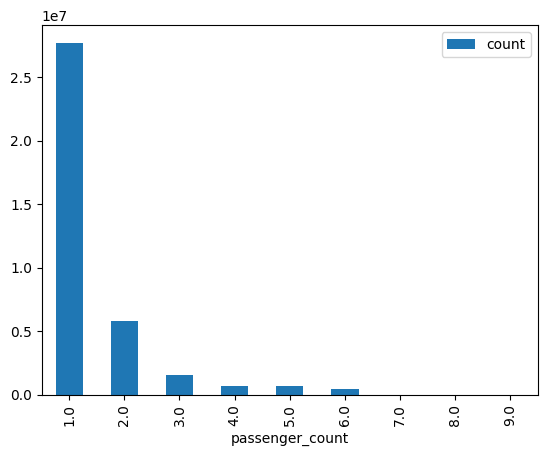

In [10]:
data.groupBy("passenger_count").count().sort(F.col("passenger_count").asc()).show()
data.groupBy("passenger_count").count().sort(F.col("passenger_count").asc()).toPandas().plot(x="passenger_count", y="count", kind="bar")

Q8 – Vérifier que toutes les lignes ont bien une date de début et de fin de trajet en 2022. Sinon, supprimez les lignes qui n’ont pas une date correcte.

In [11]:
data = data.filter(data.tpep_pickup_datetime >= "2022-01-01 00:00:00").filter(data.tpep_pickup_datetime <= "2022-12-31 23:59:59")
data = data.filter(data.tpep_dropoff_datetime >= "2022-01-01 00:00:00").filter(data.tpep_dropoff_datetime <= "2022-12-31 23:59:59")

Q9 – Une fois, vos données nettoyées, vous pouvez les stocker et ne travailler que sur celles-ci pour la suite du TP.

In [12]:
data.count()

36817073

# Exercice 3 : Data Analysis (featuring DataViz)

Q1 – Calculer le nombre de trajets effectués pour chaque jour de l’année

In [13]:
from pyspark.sql.functions import dayofyear, dayofmonth, dayofweek, hour, month

data.select("tpep_pickup_datetime") \
    .groupBy(dayofyear("tpep_pickup_datetime").alias("days")) \
    .count() \
    .orderBy("days") \
    .show()

+----+-----+
|days|count|
+----+-----+
|   1|58855|
|   2|54913|
|   3|67987|
|   4|70304|
|   5|70131|
|   6|75273|
|   7|66977|
|   8|78514|
|   9|60302|
|  10|69083|
|  11|72784|
|  12|75584|
|  13|80035|
|  14|87980|
|  15|83046|
|  16|67727|
|  17|59627|
|  18|79570|
|  19|81306|
|  20|85063|
+----+-----+
only showing top 20 rows



Q2 – Créer un graphique qui montre cette évolution

<Axes: xlabel='days'>

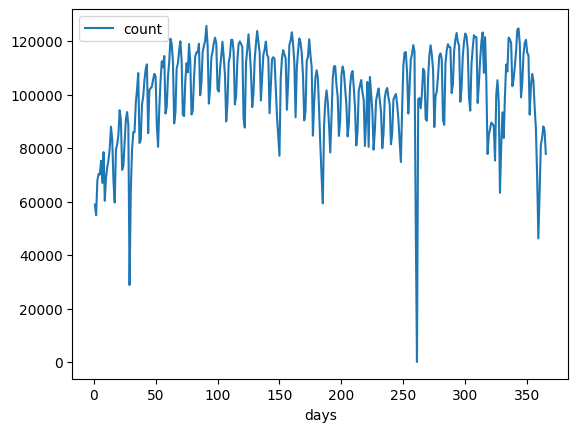

In [14]:
data.select("tpep_pickup_datetime") \
    .groupBy(dayofyear("tpep_pickup_datetime").alias("days")) \
    .count() \
    .orderBy("days") \
    .toPandas() \
    .plot(kind="line", x="days", y="count")

Q3 – Calculer le nombre de trajets pour chaque jour [Monday, Tuesday, Wednesday, Thursday, Friday,
Saturday, Sunday]

In [15]:
data.select("tpep_pickup_datetime") \
    .groupBy(dayofweek("tpep_pickup_datetime").alias("days")) \
    .count() \
    .orderBy("days") \
    .show()

+----+-------+
|days|  count|
+----+-------+
|   1|4412286|
|   2|4748627|
|   3|5390003|
|   4|5551747|
|   5|5706427|
|   6|5617662|
|   7|5390321|
+----+-------+



Q4 – Créer un histogramme qui montre la distribution

<Axes: xlabel='days'>

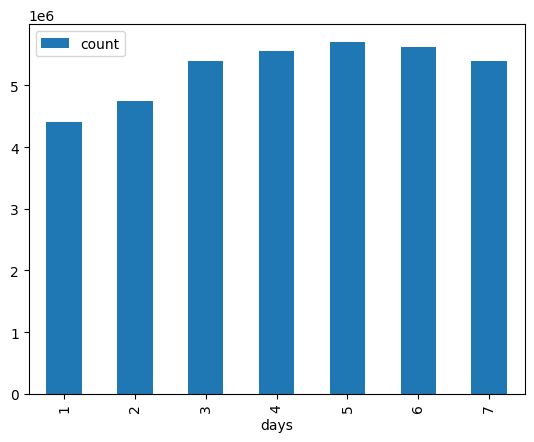

In [16]:
data.select("tpep_pickup_datetime") \
    .groupBy(dayofweek("tpep_pickup_datetime").alias("days")) \
    .count() \
    .orderBy("days") \
    .toPandas() \
    .plot(kind="bar", x="days", y="count")

Q5 – Calculer le nombre de trajets et la distance moyenne pour chaque intervalle

In [17]:
data.groupBy(hour("tpep_pickup_datetime").alias("hours")) \
    .agg(
        F.count("*").alias("number_of_trips"),
        F.avg("trip_distance").alias("average_distance")
    ) \
    .orderBy("hours") \
    .show()

+-----+---------------+------------------+
|hours|number_of_trips|  average_distance|
+-----+---------------+------------------+
|    0|        1013895| 4.189668318711498|
|    1|         664924| 3.753724606120408|
|    2|         439296| 3.499697129042836|
|    3|         285464|3.7582130846621626|
|    4|         184616| 5.182583903886989|
|    5|         218058| 6.256698814076986|
|    6|         551346| 4.880415800604333|
|    7|        1034627| 3.830471251958444|
|    8|        1385292|3.4145297742281038|
|    9|        1585858| 3.217797110460096|
|   10|        1765140| 3.180573693871305|
|   11|        1918067| 3.170330952985506|
|   12|        2067526| 3.281683572540336|
|   13|        2109128| 3.442905067876388|
|   14|        2256032| 3.573441046049015|
|   15|        2309618|3.6482995110014156|
|   16|        2289775| 3.561810854778328|
|   17|        2483125|3.3147719184495594|
|   18|        2606630|3.1224580818911947|
|   19|        2369018|3.2871154714738497|
+-----+----

Q6 – Créer les visualisations qui montrent ces distributions ? à quelle heures sont les trajets les plus
courts ? Pour quels raisons à votre avis ?

<Axes: xlabel='hours'>

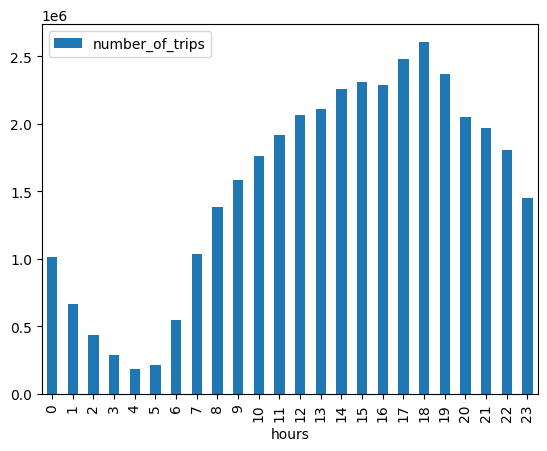

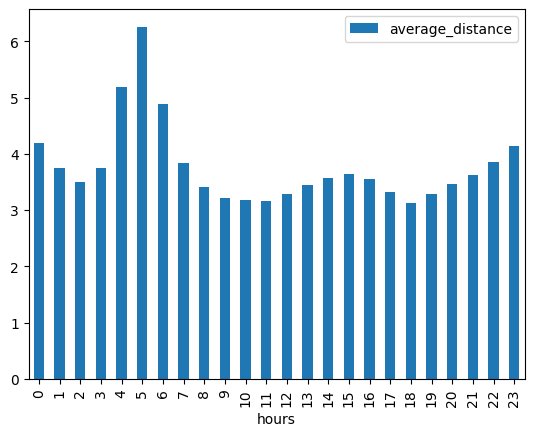

In [18]:
data.groupBy(hour("tpep_pickup_datetime").alias("hours")) \
    .agg(
        F.count("*").alias("number_of_trips"),
    ) \
    .orderBy("hours") \
    .toPandas() \
    .plot(kind="bar", x="hours", y="number_of_trips")

data.groupBy(hour("tpep_pickup_datetime").alias("hours")) \
    .agg(
        F.avg("trip_distance").alias("average_distance")
    ) \
    .orderBy("hours") \
    .toPandas() \
    .plot(kind="bar", x="hours", y="average_distance")

Q7 – Quelles méthodes de paiement sont les plus populaires ? Afficher le pourcentage de chacune des catégories de paiement

In [19]:
nb_trips = data.count()

data.groupBy("payment_type") \
    .count() \
    .withColumn("percentage", F.round(F.col("count") / nb_trips * 100, 2)) \
    .orderBy(F.col("percentage").desc()) \
    .show()

+------------+--------+----------+
|payment_type|   count|percentage|
+------------+--------+----------+
|           1|29216500|     79.36|
|           2| 7418910|     20.15|
|           3|   98582|      0.27|
|           4|   83080|      0.23|
|           5|       1|       0.0|
+------------+--------+----------+



Q8 – Quelle est la durée moyenne d’un trajet pour chaque mois ?

In [20]:
data.select("tpep_pickup_datetime", "tpep_dropoff_datetime") \
    .withColumn("duration", F.unix_timestamp("tpep_dropoff_datetime") - F.unix_timestamp("tpep_pickup_datetime")) \
    .groupBy(F.month("tpep_pickup_datetime").alias("month")) \
    .agg(F.avg("duration").alias("average_duration")) \
    .orderBy("month") \
    .show()

+-----+------------------+
|month|  average_duration|
+-----+------------------+
|    1| 854.7855791943691|
|    2| 941.5112405976662|
|    3|  979.601150401697|
|    4| 1043.872508106071|
|    5| 1097.134243436576|
|    6| 1090.719122002895|
|    7|1016.4181846434772|
|    8|1026.2733986048827|
|    9|1129.2753415915024|
|   10|1087.6125505592959|
|   11|1092.2331565021873|
|   12| 1103.255297850995|
+-----+------------------+



Q9 – Est ce que les clients donnent plus de pourboires pendant les weekends comparé aux autres jours
de la semaine ?

In [21]:
tips = (
    data.withColumn("day_of_week", F.dayofweek(F.col("tpep_pickup_datetime")))
    .groupBy("day_of_week")
    .agg(F.avg("tip_amount").alias("average_tip"))
    .orderBy("day_of_week")
)

tips.show()
tips = tips.toPandas()

print("Avrage weekday tip :",   tips[tips["day_of_week"] <= 5 ]["average_tip"].mean())
print("Avrage weekend tip :",   tips[tips["day_of_week"] > 5 ]["average_tip"].mean())


+-----------+------------------+
|day_of_week|       average_tip|
+-----------+------------------+
|          1|2.7911125548073543|
|          2|  2.76024488341585|
|          3| 2.722819436278987|
|          4| 2.744387019077562|
|          5| 2.776245634966175|
|          6|2.7338758259223925|
|          7|2.5808504391486515|
+-----------+------------------+



Avrage weekday tip : 2.758961905709186
Avrage weekend tip : 2.6573631325355223


# Exercice 4 : Quartiers les plus prisées de New York

Importer les données

In [22]:
loc_data = spark.read.option("header", "true").csv("file:///home/victor/Epita/ING2/BDA/TP5/datasets/taxi_zone_lookup.csv")

loc_data.head(5)

[Row(LocationID='1', Borough='EWR', Zone='Newark Airport', service_zone='EWR'),
 Row(LocationID='2', Borough='Queens', Zone='Jamaica Bay', service_zone='Boro Zone'),
 Row(LocationID='3', Borough='Bronx', Zone='Allerton/Pelham Gardens', service_zone='Boro Zone'),
 Row(LocationID='4', Borough='Manhattan', Zone='Alphabet City', service_zone='Yellow Zone'),
 Row(LocationID='5', Borough='Staten Island', Zone='Arden Heights', service_zone='Boro Zone')]

Q1 – Faire la jointure entre les deux datasets pour récupérer l’arrondissement et la zone pour chaque
trajet.

In [23]:
dropoff_loc_alias = loc_data.alias("dropoff")

data_with_pickup = data.join(loc_data, data.PULocationID == loc_data.LocationID, "left_outer")
data_with_pickup = data_with_pickup.withColumnRenamed("LocationID", "pickup_LocationID") \
    .withColumnRenamed("Borough" , "pickup_Borough") \
    .withColumnRenamed("Zone" , "pickup_Zone") \
    .withColumnRenamed("service_zone" , "pickup_service_zone")

data_complete = data_with_pickup.join(dropoff_loc_alias, data.DOLocationID == F.col("dropoff.LocationID"), "left_outer")
data_complete = data_complete.withColumnRenamed("LocationID", "dropoff_LocationID") \
    .withColumnRenamed("Borough" , "dropoff_Borough") \
    .withColumnRenamed("Zone" , "dropoff_Zone") \
    .withColumnRenamed("service_zone" , "dropoff_service_zone")

data_complete.head(5)

[Row(VendorID=1, tpep_pickup_datetime=datetime.datetime(2022, 10, 1, 0, 3, 41), tpep_dropoff_datetime=datetime.datetime(2022, 10, 1, 0, 18, 39), passenger_count=1.0, trip_distance=1.7, RatecodeID=1.0, store_and_fwd_flag='N', PULocationID=249, DOLocationID=107, payment_type=1, fare_amount=9.5, extra=3.0, mta_tax=0.5, tip_amount=2.65, tolls_amount=0.0, improvement_surcharge=0.3, total_amount=15.95, congestion_surcharge=2.5, airport_fee=0.0, pickup_LocationID='249', pickup_Borough='Manhattan', pickup_Zone='West Village', pickup_service_zone='Yellow Zone', dropoff_LocationID='107', dropoff_Borough='Manhattan', dropoff_Zone='Gramercy', dropoff_service_zone='Yellow Zone'),
 Row(VendorID=2, tpep_pickup_datetime=datetime.datetime(2022, 10, 1, 0, 14, 30), tpep_dropoff_datetime=datetime.datetime(2022, 10, 1, 0, 19, 48), passenger_count=2.0, trip_distance=0.72, RatecodeID=1.0, store_and_fwd_flag='N', PULocationID=151, DOLocationID=238, payment_type=2, fare_amount=5.5, extra=0.5, mta_tax=0.5, tip_

Q2 – Quelles sont les tops destinations (top 4 des zones) ? et d’ou les trajets correspondants
commencent t’ils ?

In [24]:
top_4 = data_complete.groupBy("Dropoff_Zone").count().orderBy(F.desc("count")).limit(4)

print("Top 4 destinations :")
top_4.show()

print("Debut des trajets coresspondants :")
for row in top_4.collect():
    destination = row['Dropoff_Zone']
    print(destination)
    data_complete.filter(data_complete["Dropoff_Zone"] == destination) \
                .groupBy("Pickup_Zone") \
                .count() \
                .orderBy(F.desc("count")) \
                .limit(5) \
                .show()

Top 4 destinations :


+--------------------+-------+
|        Dropoff_Zone|  count|
+--------------------+-------+
|Upper East Side N...|1601756|
|Upper East Side S...|1526927|
|      Midtown Center|1359992|
|         Murray Hill|1099527|
+--------------------+-------+

Debut des trajets coresspondants :


Upper East Side North


+--------------------+------+
|         Pickup_Zone| count|
+--------------------+------+
|Upper East Side S...|247615|
|Upper East Side N...|153072|
|      Midtown Center| 88145|
|     Lenox Hill West| 86952|
|Upper West Side S...| 67456|
+--------------------+------+

Upper East Side South


+--------------------+------+
|         Pickup_Zone| count|
+--------------------+------+
|Upper East Side N...|209015|
|Upper East Side S...|161234|
|      Midtown Center| 98965|
|        Midtown East| 71032|
| Lincoln Square East| 68874|
+--------------------+------+

Midtown Center


+--------------------+------+
|         Pickup_Zone| count|
+--------------------+------+
|Upper East Side S...|108661|
|Upper East Side N...| 83100|
|Penn Station/Madi...| 75986|
| Lincoln Square East| 52822|
|      Midtown Center| 51736|
+--------------------+------+

Murray Hill


+--------------------+-----+
|         Pickup_Zone|count|
+--------------------+-----+
|            Gramercy|66643|
|            Union Sq|57526|
|Penn Station/Madi...|56980|
|        Midtown East|50778|
|      Midtown Center|49248|
+--------------------+-----+



# Exercice 5 : Impact de la météo sur les trajets

Importer les donnees

In [25]:
from datetime import datetime

weather_rdd = spark.sparkContext.textFile('file:///home/victor/Epita/ING2/BDA/TP5/datasets/725053-94728-2022')

def parse_line(line):
    date = line[15:23]
    time = line[23:27]
    date_time = datetime.strptime(date + time, "%Y%m%d%H%M")
    temp = int(line[88:92]) / 10 * (1 if line[87] == '+' else -1)
    if -100 <= temp <= 150:
        return (date_time, temp)
    return None

wdata = weather_rdd.map(parse_line).filter(lambda x: x is not None)
wdata_df = wdata.toDF(["date_time", "temp"])
wdata_df.show(10)

+-------------------+----+
|          date_time|temp|
+-------------------+----+
|2022-01-01 00:15:00|10.6|
|2022-01-01 00:51:00|10.6|
|2022-01-01 01:49:00|11.0|
|2022-01-01 01:51:00|10.6|
|2022-01-01 02:51:00|11.1|
|2022-01-01 03:51:00|10.6|
|2022-01-01 04:49:00|11.0|
|2022-01-01 04:51:00|10.6|
|2022-01-01 05:51:00|10.6|
|2022-01-01 06:51:00|10.6|
+-------------------+----+
only showing top 10 rows



Q1 – Comment le nombre de trajets varie en fonction de la température qu’il fait ?

In [26]:
from pyspark.sql.functions import to_date

data_with_date = data.withColumn("date", to_date("tpep_pickup_datetime"))
wdata_df_with_date = wdata_df.withColumn("date", to_date("date_time"))

data_weather = data_with_date.join(wdata_df_with_date, "date")
data_weather.show(5)

+----------+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-------------------+----+
|      date|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|          date_time|temp|
+----------+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-------------------+----+
|2022-10-19|       2| 2022-10-19 00:00:57|  2022-10-19 00:46:30|            1.0

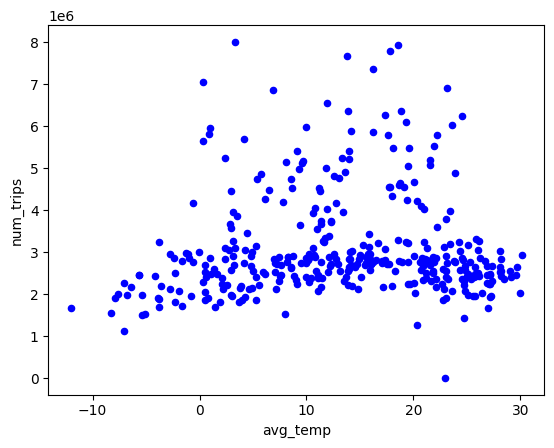

In [27]:
daily_stats = data_weather.groupBy(F.date_trunc('day', 'date_time').alias('day')) \
    .agg(
        F.mean('temp').alias('avg_temp'),
        F.count('*').alias('num_trips')
    ) \
    .orderBy('day') \
    .toPandas() \
    .plot(kind="scatter", x="avg_temp", y="num_trips", color='blue')

# Exercice 6 : Machine Learning (Mllib)

Q1 – Implémenter un modèle de régression de votre choix avec tout le pipeline, préparation des données, splits, train, loss, évaluation des prédictions.

Estimer le prix d'un trajet en fonction de la distance et de la duree du trajet

In [28]:
data = data.withColumn("trip_duration", F.unix_timestamp("tpep_dropoff_datetime") - F.unix_timestamp("tpep_pickup_datetime"))
selected_data = data.select(F.col("trip_distance"), F.col("trip_duration"), F.col("total_amount"))

Combiner les caracteristiques en vacteur

In [29]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline

featureAssembler = VectorAssembler(inputCols=["trip_distance", "trip_duration"], outputCol="features")

gbt = GBTRegressor(featuresCol="features", labelCol="total_amount")
# rf = RandomForestRegressor(featuresCol="features", labelCol="total_amount")

pipeline = Pipeline(stages=[featureAssembler, gbt])

# Divide data
train_data, test_data = selected_data.randomSplit([0.7, 0.3], seed=42)

# Train model
model = pipeline.fit(train_data)


In [31]:
from pyspark.ml.evaluation import RegressionEvaluator

predictions = model.transform(test_data)

evaluator = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"RMSE sur l'ensemble de test = {round(rmse, 2)}")

RMSE sur l'ensemble de test = 6.73


# Exercice 7 : Movies

Q1 – Construire les deux dataframes correspondants aux jeux de données.

Q2 – Combien de films y a t’il dans le jeu de données ?

Q3 – Construire une nouvelle colonnes qui va contenir l’année de sortie de chaque film. Cette donnée
se trouve en parenthèse à la fin de chaque titre de film

Q4 – Donner la liste de tous les genres de films disponible.

Q5 – Construire une liste de films par genres, i.e., répertorier tous les films pour les genres "Drama",
"Romance", etc.

Q6 – Trouver le nombre de films pour chaque appréciation (rating 1, 2, 3, 4 et 5)

Q7 – Quels sont les 10 films qui ont été regardé le plus de fois (par le plus d’utilisateurs) ?